In [1]:
!pip install torch torchvision matplotlib scikit-image --quiet

In [2]:
import math
import random
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from skimage.restoration import denoise_nl_means

In [3]:
def imshow_tensor(img_tensor, title=None):
    """
    img_tensor: (C,H,W) in [0,1]
    """
    img_np = img_tensor.detach().cpu().numpy()
    img_np = np.transpose(img_np, (1, 2, 0))  # (H,W,C)
    img_np = np.clip(img_np, 0.0, 1.0)
    plt.imshow(img_np)
    if title is not None:
        plt.title(title)
    plt.axis("off")


def batch_psnr(pred, target):
    """
    pred, target: (B,C,H,W) in [0,1]
    returns mean PSNR over batch
    """
    mse = F.mse_loss(pred, target, reduction='none')
    mse = mse.view(mse.size(0), -1).mean(dim=1)  # per-sample
    psnr = 10 * torch.log10(1.0 / (mse + 1e-10))
    return psnr.mean().item()

In [4]:
class STL10DenoiseNLM(Dataset):
    """
    STL10-based denoising dataset for Non-Local Means.
    Returns:
        noisy: (3,H,W) in [0,1]
        clean: (3,H,W) in [0,1]
        sigma: (1,1,1) scalar noise level in [0,1]
    """
    def __init__(self, root, split='train',
                 sigma_range=(0.0, 50.0/255.0),
                 download=True):
        super().__init__()

        self.dataset = torchvision.datasets.STL10(
            root=root,
            split=split,            # 'train' or 'test'
            download=download,
            transform=transforms.ToTensor()  # (3,96,96) in [0,1]
        )
        self.sigma_range = sigma_range

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        clean, _ = self.dataset[idx]   # (3,96,96)

        # Choose sigma
        if self.sigma_range[0] == self.sigma_range[1]:
            sigma = self.sigma_range[0]
        else:
            sigma = random.uniform(*self.sigma_range)

        sigma_tensor = torch.tensor([[[sigma]]], dtype=clean.dtype)  # (1,1,1)

        # Add AWGN
        noise = torch.randn_like(clean) * sigma
        noisy = (clean + noise).clamp(0.0, 1.0)

        return noisy, clean, sigma_tensor

In [ ]:
data_root = "./Datasets/data_stl10"

# Train: random sigma in [0, 50/255]
train_dataset_full = STL10DenoiseNLM(
    root=data_root,
    split='train',
    sigma_range=(0.0, 50.0/255.0),
    download=True
)

# Test: fixed sigma = 25/255
sigma_test = 25.0 / 255.0
test_dataset_full = STL10DenoiseNLM(
    root=data_root,
    split='test',
    sigma_range=(sigma_test, sigma_test),
    download=True
)

print("Full STL10 train size:", len(train_dataset_full))  # 5000
print("Full STL10 test size:", len(test_dataset_full))    # 8000

# Use subsets for speed (NLM is slower than CNNs)
max_train_samples = 2000
max_test_samples  = 500

train_indices = torch.randperm(len(train_dataset_full))[:max_train_samples]
test_indices  = torch.randperm(len(test_dataset_full))[:max_test_samples]

train_dataset = Subset(train_dataset_full, train_indices)
test_dataset  = Subset(test_dataset_full, test_indices)

print("Subset train size:", len(train_dataset))
print("Subset test size:", len(test_dataset))

100%|██████████| 2.64G/2.64G [35:00<00:00, 1.26MB/s]


Full STL10 train size: 5000
Full STL10 test size: 8000
Subset train size: 2000
Subset test size: 500


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

use_pin_memory = (device.type == "cuda")

train_loader = DataLoader(
    train_dataset,
    batch_size=8,     # small batch, because NLM runs per-image on CPU
    shuffle=True,
    num_workers=0,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=use_pin_memory
)

Using device: cpu


In [7]:
def nlm_denoise_image(noisy_img, sigma,
                      patch_size=5,
                      patch_distance=6,
                      fast_mode=True):
    """
    Non-Local Means denoising for a single image.

    noisy_img: torch.Tensor (C,H,W) in [0,1]
    sigma: scalar noise std in [0,1] (float)
    """
    # Convert to numpy, HxWxC
    noisy_np = noisy_img.detach().cpu().numpy()
    noisy_np = np.transpose(noisy_np, (1, 2, 0))  # (H,W,C)

    # NLM parameter h is usually proportional to sigma
    h = 0.8 * sigma

    # For modern scikit-image, use channel_axis=-1
    denoised_np = denoise_nl_means(
        noisy_np,
        h=h,
        patch_size=patch_size,
        patch_distance=patch_distance,
        fast_mode=fast_mode,
        channel_axis=-1  # color image, last axis is channels
    )

    # Back to torch, (C,H,W)
    denoised_np = np.clip(denoised_np, 0.0, 1.0)
    denoised_t = torch.from_numpy(np.transpose(denoised_np, (2, 0, 1))).float()
    return denoised_t


def nlm_denoise_batch(noisy_batch, sigma_batch,
                      patch_size=5,
                      patch_distance=6,
                      fast_mode=True):
    """
    Apply NLM to a batch of images.

    noisy_batch:  (B,C,H,W)
    sigma_batch:  (B,1,1,1) — each image can have its own sigma
    """
    B, C, H, W = noisy_batch.shape
    denoised_list = []
    for i in range(B):
        noisy_img = noisy_batch[i]
        sigma_i = float(sigma_batch[i].item())
        denoised_img = nlm_denoise_image(
            noisy_img,
            sigma_i,
            patch_size=patch_size,
            patch_distance=patch_distance,
            fast_mode=fast_mode
        )
        denoised_list.append(denoised_img)
    denoised_batch = torch.stack(denoised_list, dim=0)  # (B,C,H,W)
    return denoised_batch


In [8]:
max_batches_eval = 20  # limit for speed; increase if you want more accurate stats

test_psnr_total = 0.0
num_batches = 0

for batch_idx, (noisy, clean, sigma) in enumerate(test_loader):
    if batch_idx >= max_batches_eval:
        break

    noisy = noisy.to(device)   # though NLM runs on CPU, we keep interface consistent
    clean = clean.to(device)
    sigma = sigma.to(device)

    # Run NLM on CPU tensors
    denoised = nlm_denoise_batch(
        noisy.cpu(), sigma.cpu(),
        patch_size=5,
        patch_distance=6,
        fast_mode=True
    ).to(device)

    psnr_batch = batch_psnr(denoised, clean)
    test_psnr_total += psnr_batch
    num_batches += 1

avg_test_psnr = test_psnr_total / num_batches
print(f"Average PSNR on STL10 test subset (σ={sigma_test*255:.1f}, NLM): {avg_test_psnr:.2f} dB")

Average PSNR on STL10 test subset (σ=25.0, NLM): 26.71 dB


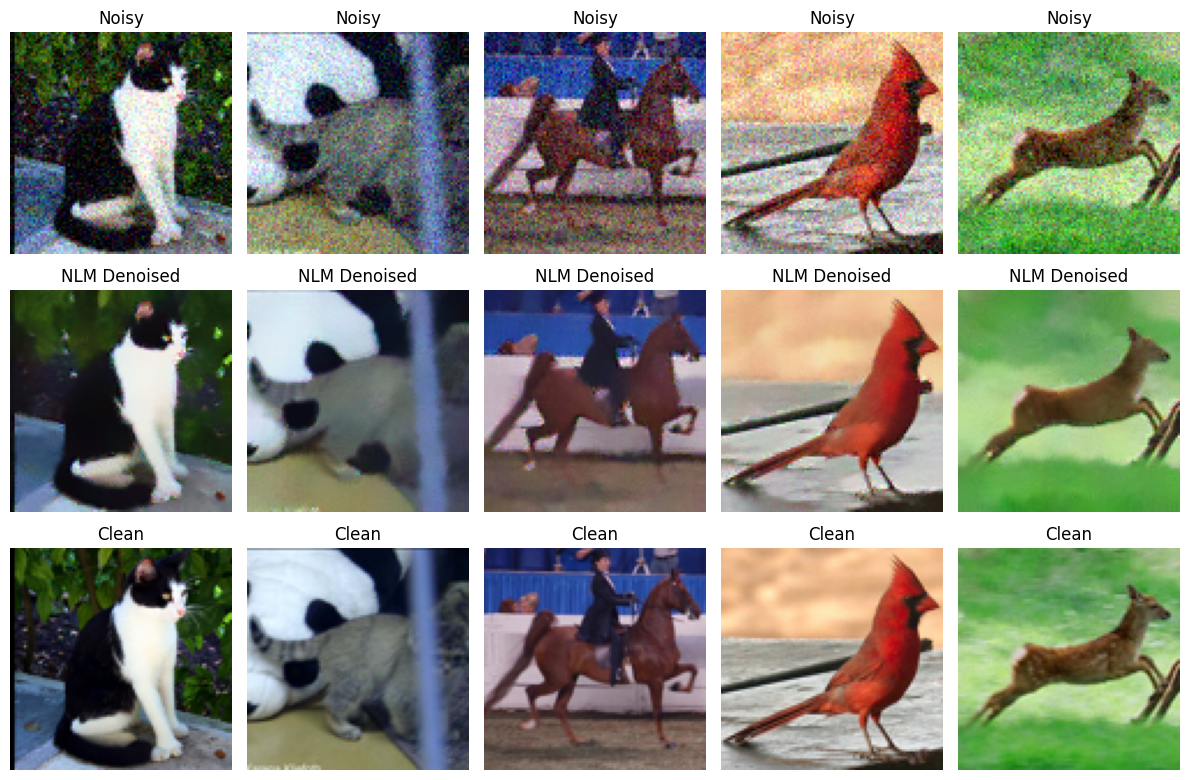

In [9]:
# Take one batch from test_loader
noisy_batch, clean_batch, sigma_batch = next(iter(test_loader))

# Denoise with NLM
denoised_batch = nlm_denoise_batch(
    noisy_batch,
    sigma_batch,
    patch_size=5,
    patch_distance=6,
    fast_mode=True
)

N_show = 5
plt.figure(figsize=(12, 8))
for i in range(N_show):
    # Noisy
    plt.subplot(3, N_show, i + 1)
    imshow_tensor(noisy_batch[i], title="Noisy")

    # Denoised
    plt.subplot(3, N_show, N_show + i + 1)
    imshow_tensor(denoised_batch[i], title="NLM Denoised")

    # Clean
    plt.subplot(3, N_show, 2 * N_show + i + 1)
    imshow_tensor(clean_batch[i], title="Clean")

plt.tight_layout()
plt.show()